In [295]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

$r(x)=q(x)+p(x)$  
$r(x)=\frac{1}{n} \sum\limits_{i=1}^{N} f_i(x)= \sum\limits_{j=1}^{M} f_j(x)+\frac{1}{n}\sum\limits_{i=1}^{N} [f_i(x)-\sum\limits_{j=1}^M f_j(x)]$     
$q(x)=\sum\limits_{j=1}^{M} f_j(x),\;\;\; p(x)=\frac{1}{n}\sum\limits_{i=1}^{N} [f_i(x)-\sum\limits_{j=1}^M f_j(x)]$


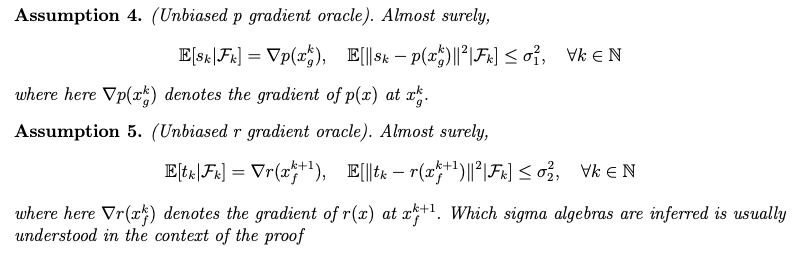

# Код реализации стох алгоритма

## Вспомогательные функции

### Класс квадратичных функций

In [296]:
#Зададим класс квадратичной функции
class quadFunction:
    # Конструктор принимает основную матрицу A, вектор b, константы выпуклости m,L и по необходимости коэффициент для L2 регуляризации
    def __init__(self, matrix, vector, mu, L, regCoef = 0):
        self.d = len(matrix)
        self.L = L
        self.mu = mu
        self.regCoef = regCoef
        self.A = matrix
        self.vector = vector

    def getGrad(self, x):
        return (np.matmul(self.A,x) - self.vector)+2*self.regCoef*x

    def getmu(self):
        return self.mu

    def getL(self):
        return self.L

    def getFunc(self,x):
        A=self.A
        vector=self.vector
        regCoef=self.regCoef
        return (0.5*np.matmul(x.T,np.matmul(A,x))-np.matmul(vector,x))+regCoef*np.matmul(x.T,x)

    def getMatrix(self):
        return self.A

    def getVector(self):
        return self.vector

    def getParams(self):
        return [self.d, self.m, self.L, self.regulizer]

### Функции - фабрики, которые принимают массив функций и возвращают различные варианты p,q,r

In [297]:
def get_det_r(functions):
  clients = len(functions)
  def r(x):
    summ=0
    for i in range(0, clients):
      summ+=functions[i].getFunc(x)
    return summ/clients
  return r

def get_det_grad_r(functions):
  clients=len(functions)
  def grad_r(x):
    summ=np.zeros(len(x))
    for i in range(0,clients):
      summ+=functions[i].getGrad(x)
    return summ/clients
  return grad_r

In [298]:
#Эта функция нужна для работы рандомного шевеления градиента на процент - один из стох. оракулов
#Возвращает равномерное распределение в центре +- coef*center. т.е. если center = 1, coef= 0.1, то
#промежуток случайных значений будет равномерно 0.9 до 1.1
def get_centred_sample(center,coef,size):
  return (np.random.sample(size)-0.5)*(coef*center/0.5)+center

In [299]:
#q_summ_size - количество слагаемых в q

#Честная функция
def get_det_q(functions, q_summ_size = 1):
  def q(x):
    summ = 0
    for i in range(0, q_summ_size):
      summ+=functions[i].getFunc(x)
    summ=summ
    return summ
  return q

#Честный градиент
def get_det_grad_q(functions, q_summ_size = 1):
  def grad_q(x):
    summ=np.zeros(len(x))
    for i in range(0,q_summ_size):
      summ=summ+functions[i].getGrad(x)
    return summ
  return grad_q

#Градиент - случайное слагаемое из суммы, умноженное на размер суммы
def get_stoch_grad_q(functions, q_summ_size = 1):
  if (q_summ_size == 1) : #базовый случай совпадает с детерменированным
    return get_det_grad_q(functions, 1)
  def grad_q(x):
    j = np.random.randint(0,q_summ_size)
    return functions[j].getGrad(x)*q_summ_size
  return grad_q

#То же что и прошлое, но теперь индексом можно управлять снаружи
def get_stoch_grad_q_managable_index(functions, q_summ_size = 1):
  functions=np.array(functions) #AAAAAAAAAA
  if (q_summ_size == 1) : #базовый случай совпадает с детерменированным
    return get_det_grad_q(functions, 1)
  def grad_q(x, random_index = 10000):
    return functions[random_index].getGrad(x)*q_summ_size
  return grad_q

# наивная стохастика - случайное равномерное шевеление градиента на какое-то количество процентов вверх и вниз
# подразумевается работа только с q_summ_size = 1
def get_stoch_uni_q(functions, percent = 5):
  def grad_q(x):
    det_grad = functions[0].getGrad(x)
    stoch_grad = det_grad*get_centred_sample(1,percent/100,len(x)) #шевелит градиент равномерно на percent процентов
    return stoch_grad
  return grad_q

In [300]:
#Функция p задается через функции r и q
#поэтому наличие стохастики в q сразу дает стохастику в r
def get_p(r,q):
  def p(x):
    return r(x)-q(x)
  return p

def get_grad_p(grad_r,grad_q):
  def grad_p(x):
    return grad_r(x)-grad_q(x)
  return grad_p


### Функции шага

In [301]:
# Функции шага

# Обычный константный шаг 1/L
def classic_step(it_num,L):
  return 1/L/2

def smart_variable_step(it_num, L):
  return 2/L/np.sqrt(it_num)

def min_balanced_step(it_num, L):
  return min(1/L/2,1/np.sqrt(it_num)/10)

def min_balanced_step_variation(it_num, L, coef):
  return min(1/L/2,1/np.sqrt(it_num)/coef)

## Функция минимизации подзадачи

В зависимости от значения argmin_mod меняется возвращаемая точка.
- "last" - возвращается последняя точка
- "mean" - возвращает среднее по всем точкам
- "mean_10" - возвращает среднее по последним 10 точкам
- "min" - возвращает точку, в которой $||\nabla A||$ достигает минимума

In [302]:
def argmin_A(s_k, theta, x_kg, grad_q, real_grad_q, step, iterations, argmin_mod = "last", pars=[]):
#  print("argmin_A debug , mod = {}".format(argmin_mod))
  x_start = np.zeros(len(x_kg))
  x=x_start
  xes = [x]
  grad_A = lambda x: s_k+(x-x_kg)/theta+grad_q(x)
  min_index = 0
  min_grad_norm = np.linalg.norm(grad_A(x),2)
  logs=[min_grad_norm]

  for i in range(1,iterations):
    x=x-step(i)*grad_A(x)
    xes.append(x)
    grad_norm = np.linalg.norm(grad_A(x),2)
    logs.append(grad_norm)
    if(argmin_mod == "min"): #проверяем надо ли обновлять точку минимального градиента и если надо обновляем
      if(grad_norm < min_grad_norm):
        min_index = i
        min_grad_norm = grad_norm

  if(argmin_mod == "last"):
    return x,logs
  elif(argmin_mod == "mean"):
    x=np.mean(xes, axis = 0)
    return x,logs
  elif(argmin_mod == "mean_10"):
    assert iterations > 10
    x=np.mean(xes[-11:-1], axis = 0)
    return x,logs
  elif(argmin_mod == "min"):
    return xes[min_index],logs
  else:
    print("invalid mod")
    assert (1==0)

In [303]:
def argmin_A_SVRG(s_k, theta, x_kg, grad_q, real_grad_q, step, iterations, argmin_mod = "last", pars = [8,15]):
  #Первый аргумент pars - частота обновления точки w
  #Второй аргумент pars - размер суммы
#  print("argmin_A debug , mod = {}".format(argmin_mod))
  #grad_q здесь обязан быть в режиме managable
  x_start = np.zeros(len(x_kg))
  x=x_start
  w=x_start
  xes = [x]

  grad_A = lambda x,i: s_k+(x-x_kg)/theta+grad_q(x,i)


  refresh_rate = pars[0]
  sum_size = pars[1]
  refresh_counter = refresh_rate
  honest_grad_A = lambda x: s_k+(x-x_kg)/theta+real_grad_q(x)

  min_index = 0
  min_grad_norm = np.linalg.norm(honest_grad_A(x),2)
  logs=[min_grad_norm]
  for i in range(1,iterations):
    if(refresh_counter == refresh_rate):
      refresh_counter = 0
      w=x
      grad_Aw = honest_grad_A(w)

    refresh_counter+=1
    g = grad_A(x,i%sum_size)-grad_A(w,i%sum_size)+grad_Aw
    x=x-step(i)*g
    xes.append(x)
    grad_norm = np.linalg.norm(g,2)
    logs.append(grad_norm)
    if(argmin_mod == "min"): #проверяем надо ли обновлять точку минимального градиента и если надо обновляем
      if(grad_norm < min_grad_norm):
        min_index = i
        min_grad_norm = grad_norm

  if(argmin_mod == "last"):
    return x,logs
  elif(argmin_mod == "mean"):
    x=np.mean(xes, axis = 0)
    return x,logs
  elif(argmin_mod == "mean_10"):
    assert iterations > 10
    x=np.mean(xes[-11:-1], axis = 0)
    return x,logs
  elif(argmin_mod == "min"):
    return xes[min_index],logs
  else:
    print("invalid mod")
    assert (1==0)

## Функция Accelerated Extragradient

Чтобы инициализировать класс, ему нужно передать PQR - обертку над набором самих функций p,q,r, их честными и стох градиентами, а так же константами выпуклости эти функци. Реализация обертки ниже (см. "Обертка для pqr и функции ее создания для задачи")

In [304]:
class Accelerated_Extragradient:

    #Конструктор принимает в себя массив функций, константы выпуклости для p(x) и q(x), все необходимые функции p,q,r
    def __init__(self, PQR, argmin_method="default", pars=[]):

        #Параметры функций
        self.Lq        = PQR.Lq
        self.Lp        = PQR.Lp
        self.mu        = PQR.mu

        #Функции
        self.real_grad_r = PQR.real_grad_r
        self.r = PQR.r
        self.grad_r = PQR.grad_r

        self.q = PQR.q
        self.grad_q = PQR.grad_q
        self.real_grad_q = PQR.real_grad_q

        self.p = PQR.p
        self.grad_p = PQR.grad_p


        #Параметры для работы алгоритма
        self.tau=min(1,math.sqrt(self.mu)/(2*math.sqrt(self.Lp)))
        self.theta=1/(2*self.Lp)
        self.eta=min(1/(2*self.mu),1/(2*math.sqrt(self.mu*self.Lp)))
        self.alpha=self.mu

        #Выбор способа минимизации
        if(argmin_method == "default"):
          self.argmin_func = argmin_A
        elif(argmin_method == "SVRG"):
          self.argmin_func = argmin_A_SVRG
        else:
          assert(1==2)
        self.pars=pars

    #step - функция от номера итерации и константы выпуклости, возвращает размер шага
    def calculate(self, outer_iterations=100, inner_iterations=100, x_start = np.zeros(112),step = classic_step, theta_coef=1, argmin_mod = "last"):


        tau=self.tau
        theta=theta_coef*self.theta
        eta=self.eta
        alpha=self.alpha

        x_kf = x_start
        x_k = x_start
        x_kg = x_start
        tmpstep = lambda i : step(i, self.Lq) #Прячем константу выпуклости под ковер лямбда выражения
        norms_log = []

        for k in range(outer_iterations):
            x_kg=tau*x_k+(1-tau)*x_kf
            #Решаем подзадачу
            x_kf = self.argmin_func(s_k = self.grad_p(x_kg),theta = theta, x_kg = x_kg, grad_q = self.grad_q, real_grad_q = self.real_grad_q, step = tmpstep, iterations = inner_iterations, argmin_mod = argmin_mod, pars=self.pars)[0]
            #Итерация в основной задаче
            x_k = x_k + eta*alpha*(x_kf-x_k)-eta*self.grad_r(x_kf)
            #Смотрим норму настоящего градиента в новой точке, заносим в лог
            norms_log.append(np.linalg.norm(self.real_grad_r(x_k),2)**2)

        return x_k, norms_log

    def solve_subtask(self, subtask_number=100, inner_iterations = 100, x_start = np.zeros(112), step = classic_step, theta_coef = 1, argmin_mod = "last" ):
        tau=self.tau
        theta=theta_coef*self.theta
        eta=self.eta
        alpha=self.alpha

        x_kf = x_start
        x_k = x_start
        x_kg = x_start
        tmpstep = lambda i : step(i, self.Lq) #Прячем константу выпуклости под ковер лямбда выражения

        #Делаем subtask_number итераций внешнего алгоритма
        for k in range(subtask_number):
            x_kg=tau*x_k+(1-tau)*x_kf
            #Решаем подзадачу
            x_kf = self.argmin_func(s_k = self.grad_p(x_kg),theta = theta, x_kg = x_kg, grad_q = self.grad_q, real_grad_q = self.real_grad_q, step = tmpstep, iterations = inner_iterations, argmin_mod = argmin_mod, pars=self.pars)[0]
            #Итерация в основной задаче
            x_k = x_k + eta*alpha*(x_kf-x_k)-eta*self.grad_r(x_kf)

        #Затем делаем еще одну итерацию подзадачи и возвращаем сведения о том, как в ней убывает норма
        x_kg=tau*x_k+(1-tau)*x_kf
        return self.argmin_func(s_k = self.grad_p(x_kg),theta = theta, x_kg = x_kg, grad_q = self.grad_q, real_grad_q = self.real_grad_q, step = tmpstep, iterations = inner_iterations, argmin_mod = argmin_mod, pars=self.pars)

## Вытакскивание массива функций из датасета mushrooms



In [305]:
def get_functions_from_mushrooms(N_functions = 200, reg_coef = 1/100):
  #1. Готовим датасет
  dataset = "mushrooms.txt"
  data = load_svmlight_file(dataset)
  X, y = data[0].toarray(), data[1]
  n, d = X.shape
  y=y-1.5
  y=2*y
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.2,test_size=0.8, random_state=41)

  #2. Батчируем датасет
  batch_size = math.floor(np.shape(X_train)[0]/N_functions)
  functions = []
  for i in range(N_functions):
    A=2*np.dot(X_train[batch_size*i:batch_size*(i+1)].T,X_train[batch_size*i:batch_size*(i+1)])/batch_size
    b=2*np.dot(y_train[batch_size*i:batch_size*(i+1)].T,X_train[batch_size*i:batch_size*(i+1)])/batch_size
    L=np.linalg.norm(A)
    mu=2*L*reg_coef #константа выпуклости - удвоенный коэффициент регуляризации
    lambd = L*reg_coef
    functions.append(quadFunction(A, b, mu, L, lambd))
  print("number of functions is {}".format(len(functions)))
  return functions

## Поиск констант $L_p,L_q,\mu$

Регуляризация :

$\lambda_i=L_i * \text{regcoef}$

$r(x)=\frac{1}{n}\sum f_i(x) \rightarrow \lambda_r=\frac{1}{n}\sum \lambda_i$

Найдем $L_p$

$p(x)=\frac{1}{n}\sum\limits_{i=1}^N \left(f_i(x)- \sum\limits_{j=1}^M f_j(x) \right)$

$f_i(x)=\left(\frac{1}{2}x^tA_ix-b_i^tx\right)$

$p(x)=\frac{1}{n}\sum \left( \frac{1}{2}x^tA_ix - b_i^Tx - \sum \left( \frac{1}{2}x^tA_jx-b_j^Tx \right)\right)$

$\nabla p(x)=\frac{1}{n}\sum_i \left( A_i x-\sum_j A_j x-b_i+
\sum_j b_j \right)$

$\nabla^2 p(x)=\frac{1}{n}\sum \left(A_i-\sum_j A_j \right)$

Остается найти сумму этих матриц и посчитать их норму

$L_q$ находим просто по определению

In [306]:
#Функция принимает массив функций и размер суммы, возвращает \mu, L_p, L_q
def get_convex_props(functions, q_summ_size):
  N_functions = len(functions)
  mu_sum = 0
  L_max  = 0
  for i in range(N_functions):
    L  = functions[i].getL()
    mu = functions[i].getmu()
    mu_sum+=mu
    if (L>L_max):
        L_max=L
  mu=mu_sum/N_functions

  #Ищем константы выпуклости
  summ_A_j = functions[0].getMatrix()
  for j in range(1, q_summ_size):
    summ_A_j = summ_A_j + functions[j].getMatrix()

  summ=np.zeros_like(summ_A_j)
  for i in range(0,N_functions):
    summ = summ + (functions[i].getMatrix()-summ_A_j)
  summ=summ/N_functions

  Lp = np.linalg.norm(summ)
  Lq = 0
  for i in range(0,q_summ_size):
    Lq+=functions[i].getL()

  print( " convex constants : Lp = {}, Lq = {}".format(Lp,Lq))

  return mu, Lp, Lq

## Обертка для pqr и функции ее создания для задачи

In [307]:
class pqr_functions:
  def __init__(self,r,grad_r,real_grad_r,q,grad_q,real_grad_q,p,grad_p, mu, Lp, Lq):
    self.r = r
    self.grad_r = grad_r
    self.real_grad_r = real_grad_r
    self.q = q
    self.grad_q = grad_q
    self.real_grad_q = real_grad_q
    self.p = p
    self.grad_p = grad_p
    self.mu=mu
    self.Lp=Lp
    self.Lq=Lq

In [308]:
# функции для создания различных оберток pqr функций
def get_pqr(functions, q_summ_size=1, q_mod="det", par = 5, p_mod="sub", par_p = 5):
  mu,Lp,Lq = get_convex_props(functions, q_summ_size)
  print("q summ size is {}".format(q_summ_size))

  r = get_det_r(functions)
  grad_r = get_det_grad_r(functions)


  q = get_det_q(functions, q_summ_size)

  if(q_mod == "det"):
    print("det mod")
    grad_q = get_det_grad_q(functions,q_summ_size)
  elif(q_mod == "stoch"):
    print("stoch mod")
    grad_q = get_stoch_grad_q(functions,q_summ_size)
  elif(q_mod == "percent"):
    print("percent mod {}".format(par))
    grad_q = get_stoch_uni_q(functions, par)
  elif(q_mod == "stoch_managable"):
    print("stoch_managable mod")
    grad_q = get_stoch_grad_q_managable_index(functions,q_summ_size)
  else:
    assert (1==2)

  if(p_mod == "sub"):
    p = get_p(r,q)
    grad_p = get_grad_p(grad_r, grad_q)

  elif(p_mod == "det"):
    p = get_p(r,q)
    grad_p = get_grad_p(grad_r, get_det_grad_q(functions,q_summ_size))
  else:
    assert (1==3)

  return pqr_functions(r=r, grad_r=grad_r, real_grad_r=grad_r, q=q, grad_q=grad_q,real_grad_q= get_det_grad_q(functions,q_summ_size), p=p, grad_p=grad_p, mu=mu, Lp=Lp, Lq=Lq )

## Функция для быстрого получения работающего алгоритма

- q_summ_size - размер суммы q
- q_mod - какой оракул на градиаент q берется
- N_size - количество функций после батчирования исходного датасета
- reg_coef - $\lambda = \text{reg_coef}*L$
- par - какой процент отклонения надо брать если q_mod = "percent"

Возможные режимы работы для q :q_mod = "det", q_mod = "stoch", q_mod = "percent"

In [309]:
def get_default_task(q_summ_size = 1, q_mod = "det", N_size = 20, reg_coef = 1/100, par = 3, p_mod = "sub", return_mod="task"):
  functions = get_functions_from_mushrooms(N_functions = N_size, reg_coef=reg_coef)
  PQR = get_pqr(functions, q_summ_size, q_mod = q_mod, par = par, p_mod = p_mod)

  if(return_mod == "task"):
    return Accelerated_Extragradient(PQR)
  elif(return_mod == "task&PQR"):
    return Accelerated_Extragradient(PQR),PQR
  else:
    assert (1==2)

In [310]:
def get_SVRG_task(q_summ_size = 1, N_size = 20, reg_coef = 1/100, p_mod = "sub", refresh_rate=10, return_mod = "task"):
  assert q_summ_size > 1
  functions = get_functions_from_mushrooms(N_functions = N_size, reg_coef=reg_coef)
  PQR = get_pqr(functions, q_summ_size, q_mod = "stoch_managable", p_mod = "det")

  if(return_mod == "task"):
    return Accelerated_Extragradient(PQR, argmin_method = "SVRG", pars = [refresh_rate, q_summ_size])
  elif(return_mod == "task&PQR"):
    return Accelerated_Extragradient(PQR, argmin_method = "SVRG", pars = [refresh_rate, q_summ_size]),PQR
  else:
    assert (1==2)


# Тест : Решение подзадачи при помощи SVRG

In [311]:
def subtask_SVRG_solvabitlity_test(subtask_numbers = [1,20,100], inner = 100, q_summ_size = 15, N_size = 20, reg_coef = 1/100, p_mod="sub", refresh_rate=10):
  styles = ["-","--","-.",":","--"]
  logs = []
  for i in range(len(subtask_numbers)):
    task,PQR = get_SVRG_task(q_summ_size, N_size, reg_coef, p_mod, refresh_rate, return_mod = "task&PQR")
    step = lambda iter_number, L : min_balanced_step_variation(iter_number, L, coef = 2*np.sqrt(2)*PQR.Lq/inner)
    logs.append(task.solve_subtask( subtask_number = subtask_numbers[i], inner_iterations = inner, step = min_balanced_step, argmin_mod="mean_10" )[1])
    print("task calculated")
    plt.plot(range(len(logs[i])),logs[i], label = "subtask number = {}".format(subtask_numbers[i]), linestyle = styles[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel("number of subtask iterations")
    plt.ylabel(r"$\log ||\nabla A||$")
    plt.title("Subtask iterations test balanced step with SVRG")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated


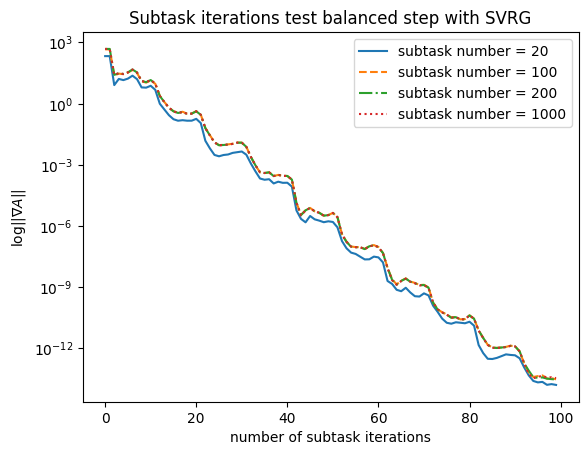

In [313]:
subtask_SVRG_solvabitlity_test([20,100,200,1000],inner = 100, q_summ_size = 15, p_mod="sub",refresh_rate = 10)

# Тест : Решение задачи при помощи SVRG

In [319]:
def qsumm_test_smart_step_SVRG(outer, inners, q_summ_size = 15, N_size = 20, reg_coef = 1/100, refresh_rate=10):
  #point_choose_mods = ["last","mean","mean_10","min"]
  #pmods = ["det","sub"]
  pmods=["det", "sub"]
  styles = [["-","--"],["-","--"],["-","--"],["-","--"]]
#point_choose_mods = point_choose_mods[1:2]

  logs = []
  for i in range(len(inners)):
    for j in range(len(pmods)):
      task = get_SVRG_task(q_summ_size, N_size, reg_coef, p_mod=pmods[j], refresh_rate=refresh_rate, return_mod = "task")
      logs = task.calculate(outer_iterations = outer, inner_iterations = inners[i], argmin_mod = "mean_10", step = smart_variable_step)[1]
      print("task calculated")
      plt.plot(range(len(logs)),logs, label = pmods[j]+str(inners[i]), linestyle = styles[i][j])

  plt.title("SVRG, sum_size = {}, refresh_rate = {}".format(q_summ_size, refresh_rate))
  plt.legend()
  plt.xlabel("Number of ASEG iterations")
  plt.yscale("log")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch_managable mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15


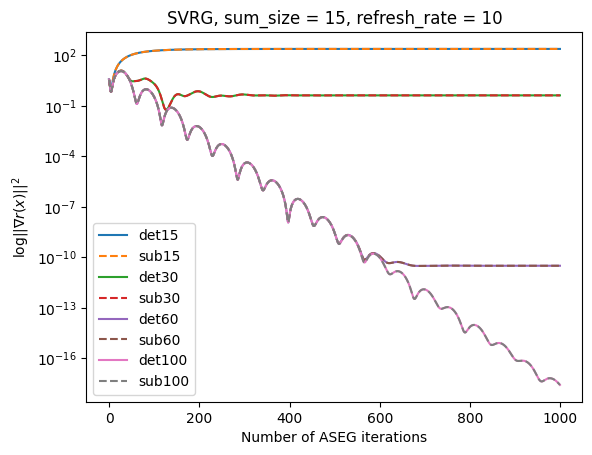

In [321]:
qsumm_test_smart_step_SVRG(1000, inners=[15,30,60,100], q_summ_size = 15, refresh_rate=10)

# Тест : решение подзадачи на различных оракулах

In [142]:
def subtask_solvabitlity_test(subtask_numbers = [1,20,100], inner = 500, q_summ_size = 1, q_mod = "det", N_size = 20, reg_coef = 1/100, percent = 3):
  functions = get_functions_from_mushrooms(N_size, reg_coef = reg_coef)
  styles = ["-","--","-.",":","--"]
  logs = []
  for i in range(len(subtask_numbers)):
    task = get_default_task(q_summ_size, q_mod, N_size, reg_coef, percent)
    step = lambda iter_number, L : min_balanced_step_variation(iter_number, L, coef = 2*np.sqrt(2)*PQR.Lq/inner)
    logs.append(task.solve_subtask( subtask_number = subtask_numbers[i], inner_iterations = inner, step = min_balanced_step, argmin_mod="mean_10" )[1])
    print("task calculated")
    plt.plot(range(len(logs[i])),logs[i], label = "subtask number = {}".format(subtask_numbers[i]), linestyle = styles[i])
    plt.legend()
    plt.yscale('log')
    plt.xlabel("number of subtask iterations")
    plt.ylabel(r"$\log ||\nabla A||$")
    if(q_mod == "percent"):
      plt.title("Subtask iterations  qmod = {} {}".format( q_mod, percent))
    else:
      plt.title("Subtask iterations test balanced step qmod = {}".format(q_mod))

number of functions is 20
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
task calculated


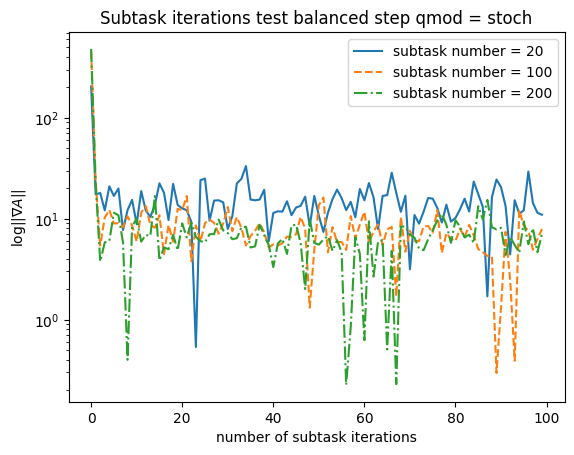

In [143]:
subtask_solvabitlity_test([20,100,200],inner = 100, q_summ_size = 15, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
task calculated
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
task calculated


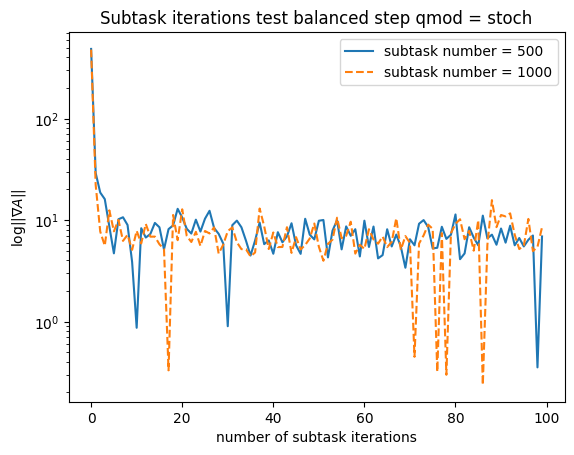

In [132]:
subtask_solvabitlity_test([500,1000],inner = 100, q_summ_size = 15, q_mod = "stoch")

## Отклонение в 20%

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated


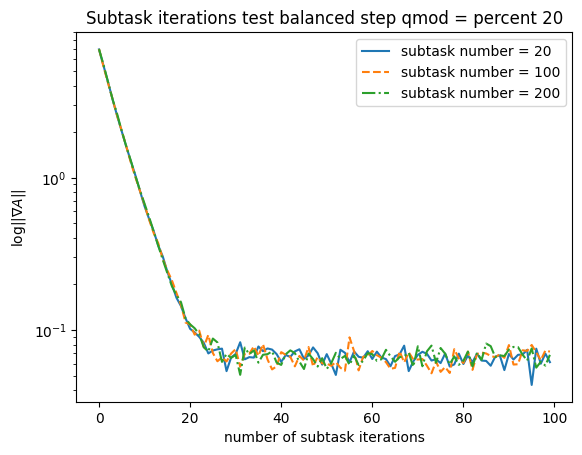

In [133]:
subtask_solvabitlity_test([20,100,200], inner = 100, q_summ_size = 1, q_mod = "percent", percent = 20)

## Отклонение в 1 %

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated


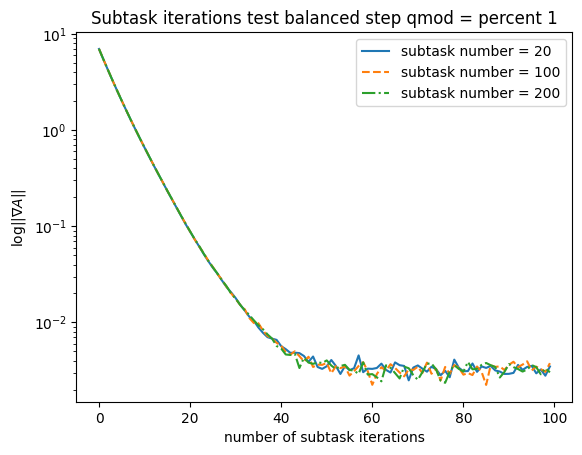

In [134]:
subtask_solvabitlity_test([20,100,200], inner = 100, q_summ_size = 1, q_mod = "percent", percent = 1)

# Тест : выполнение критерия на подзадачу


In [55]:
def subtask_criterion_test_argmin_A(s_k, theta, x_kg, grad_q, honest_grad_q, step, Lp):
  logs=[]
  x_start = np.zeros(len(x_kg))
  x_honest = x_start
  x_method = x_start

  #1. Найдем честный аргмин
  honest_grad_A = lambda x : s_k+(x-x_kg)/theta + honest_grad_q(x_honest)
  accuracy = 1E-8
  i=0
  while(np.linalg.norm(honest_grad_A(x_honest),2)**2 > accuracy):
    x_honest=x_honest-step(i)*honest_grad_A(x_honest) #возможно сюда надо будет пристроить другой шаг
    i+=1

  #2. Вычисляем значение критерия для этого шага
  criterion = 9*Lp*Lp*np.linalg.norm(x_kg-x_honest, 2)**2

  #3. Делаем итерации тестируемого алгоритма
  grad_A = lambda x: s_k+(x-x_kg)/theta+grad_q(x)
  counter = 0

  while(np.linalg.norm(grad_A(x_method),2)**2 > criterion):
    counter+=1
    x_method=x_method-step(counter)*grad_A(x_method)
    logs.append(np.linalg.norm(grad_A(x_method), 2)**2)
    if (counter>10000):
      counter=-1000
      break;

  return x_method, logs, counter

In [56]:
class subtask_criterion_test_Accelerated_Extragradient:

    #Конструктор принимает в себя массив функций, константы выпуклости для p(x) и q(x), все необходимые функции p,q,r
    def __init__(self, PQR):
        #real_grad_q отвечает настоящему не стох градиенту, он нужен только чтобы обновлять критерий, в нестох случае совп с grad_q

        #Параметры функций
        self.Lq        = PQR.Lq
        self.Lp        = PQR.Lp
        self.mu        = PQR.mu # r(x) - mu сильно выпукла

        #Функции
        self.real_grad_r = PQR.real_grad_r
        self.r = PQR.r
        self.grad_r = PQR.grad_r

        self.real_grad_q = PQR.real_grad_q
        self.q = PQR.q
        self.grad_q = PQR.grad_q

        self.p = PQR.p
        self.grad_p = PQR.grad_p


        #Параметры для работы алгоритма
        self.tau=min(1,math.sqrt(self.mu)/(2*math.sqrt(self.Lp)))
        self.theta=1/(2*self.Lp)
        self.eta=min(1/(2*self.mu),1/(2*math.sqrt(self.mu*self.Lp)))
        self.alpha=self.mu


    #step - функция от номера итерации и константы выпуклости, возвращает размер шага
    def calculate(self,outer_iterations, inner_iterations, x_start=np.zeros(112), step=classic_step, theta_coef=0.8):
        #Выносим поля класса чтобы было легче смотреть на алгоритм
        DIMENSIONS=len(x_start)  #размерность

        tau=self.tau
        theta=theta_coef*self.theta
        eta=self.eta
        alpha=self.alpha

        x_kf = x_start
        x_k = x_start
        x_kg = x_start

        norms_log = [] # лог значений нормы градиента
        counters_log = []

        for k in range(outer_iterations):
            x_kg=tau*x_k+(1-tau)*x_kf

            #Решаем подзадачу
            tmpstep = lambda i : step(i,self.Lq) #Прячем константу выпуклости под ковер лямбда выражения
            argmin_A_results = subtask_criterion_test_argmin_A(s_k = self.grad_p(x_kg),theta = theta, x_kg = x_kg, grad_q = self.grad_q, honest_grad_q = self.real_grad_q, step = tmpstep, Lp = self.Lp)
            x_kf = argmin_A_results[0]
            counters_log.append(argmin_A_results[2])
            #Итерация в основной задаче
            x_k = x_k + eta*alpha*(x_kf-x_k)-eta*self.grad_r(x_kf)
            #Смотрим норму настоящего градиента в новой точке, заносим в лог
            norms_log.append(np.linalg.norm(self.real_grad_r(x_k),2)**2)

        return x_k, norms_log, counters_log

In [57]:
def test_subtask_criterion_percents( inner=100, outer=100, percents=[1,3,5], step=classic_step):
  functions = get_functions_from_mushrooms()
  logs=[]
  for i in range(len(percents)):
    PQR = get_pqr(functions, q_summ_size = 1, q_mod = "percent", par = percents[i])
    task=subtask_criterion_test_Accelerated_Extragradient(PQR)
    logs.append(task.calculate(outer_iterations = outer, inner_iterations = inner, step = step, theta_coef=0.8)[2])

  for i in range(len(percents)):
    plt.plot(range(len(logs[i])),logs[i],label = "%err = {}".format(percents[i]))
    #  plt.plot(range(len(logs[i])),logs[i],label = "%err = {}".format(percents[i]),linestyle=styles[i])
    plt.ylabel(r"Criterion satisfaction for subtask steps")
    plt.xlabel("Number of iteration")
    plt.title("Mushrooms criterion_test test : outer = {}, inner = {}".format(outer, inner))
    plt.legend()


# Тест : сравнение детерменированного и стохастического градиента $p$, шаг балансирующий


In [135]:
def qsumm_test_smart_step_pdet(outer, inners, q_summ_size = 1, q_mod = "det", N_size = 20, reg_coef = 1/100, percent = 3):
  #point_choose_mods = ["last","mean","mean_10","min"]
  #pmods = ["det","sub"]
  pmods=["det", "sub"]
  styles = [["-","--"],["-","--"],["-","--"],["-","--"]]
#point_choose_mods = point_choose_mods[1:2]

  logs = []
  for i in range(len(inners)):
    for j in range(len(pmods)):
      task = get_default_task(q_summ_size, q_mod, N_size, reg_coef, percent, p_mod=pmods[j])
      logs = task.calculate(outer_iterations = outer, inner_iterations = inners[i], argmin_mod = "mean_10", step = smart_variable_step)[1]
      print("task calculated")
      plt.plot(range(len(logs)),logs, label = pmods[j]+str(inners[i]), linestyle = styles[i][j])

  if(q_mod == "percent"):
    plt.title("SGD, qsumm_size = {}, qmod = {} {}".format(q_summ_size, q_mod, percent))
  else:
    plt.title("SGD, qsumm_size = {}, qmod = {}".format(q_summ_size, q_mod))
  plt.legend()
  plt.xlabel("Number of ASEG iterations")
  plt.yscale("log")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
task calculated
number of functions is 20
 convex 

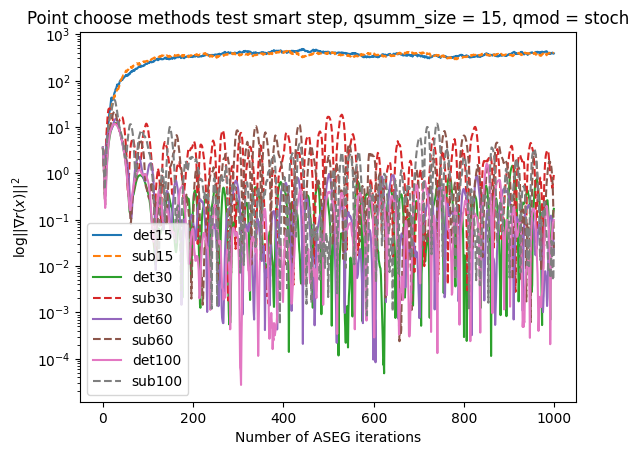

In [322]:
qsumm_test_smart_step_pdet(1000, inners = [15,30,60,100], q_summ_size = 15, q_mod = "stoch")

## Отклонение в 20%

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated


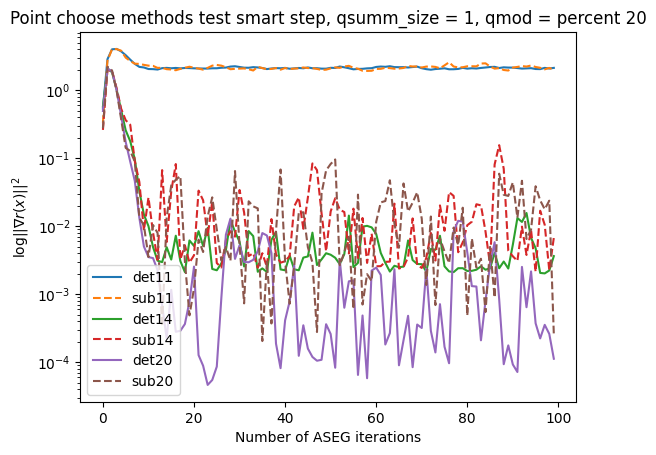

In [136]:
qsumm_test_smart_step_pdet(100, inners = [11,14,20], q_summ_size = 1, q_mod = "percent", percent = 20)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
task calculated


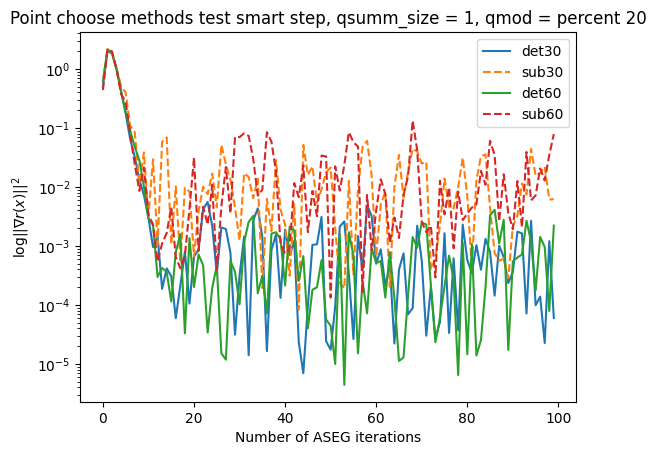

In [115]:
qsumm_test_smart_step_pdet(100, inners = [30,60], q_summ_size = 1, q_mod = "percent", percent = 20)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
task calculated


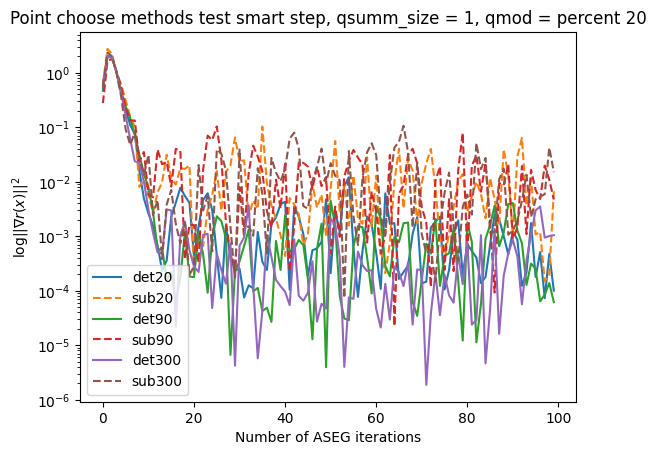

In [323]:
qsumm_test_smart_step_pdet(100, inners = [20,90,300], q_summ_size = 1, q_mod = "percent", percent = 20)

## Отклонение в 1%

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564


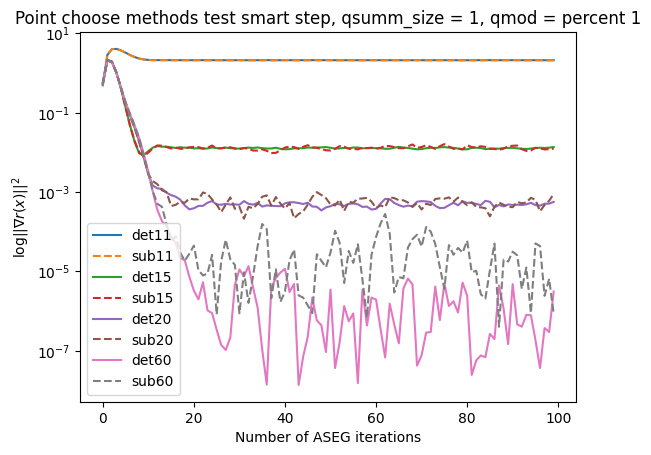

In [111]:
qsumm_test_smart_step_pdet(100, inners = [11,15,20,60], q_summ_size = 1, q_mod = "percent", percent = 1)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
detdetdet
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
task calculated


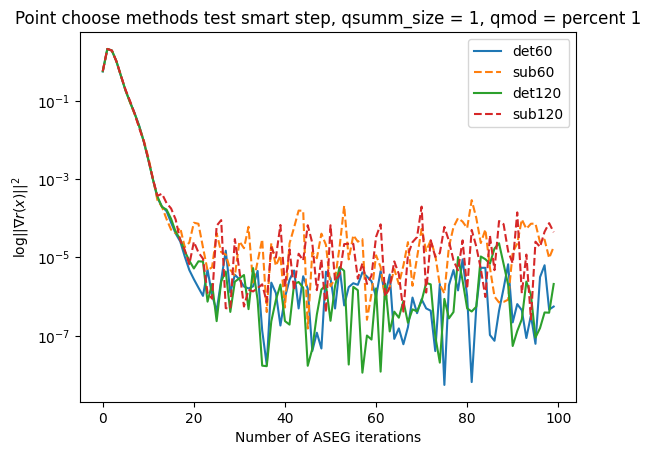

In [137]:
qsumm_test_smart_step_pdet(100, inners = [60,120], q_summ_size = 1, q_mod = "percent", percent = 1)

# Тест : сравнение способов выбора итоговой точке в подзадаче, шаг $\gamma_m$ - с середины переходит с $\frac{1}{L}$ на $\frac{1}{c\sqrt m}$, где с подбирается так, чтобы переход происходит посередине решения подзадачи

In [145]:
def qsumm_test_balanced_step(outer,inner, q_summ_size = 1, q_mod = "det", N_size = 20, reg_coef = 1/100, percent = 3, p_mod="sub"):
  point_choose_mods = ["last","mean","mean_10","min"]
  styles = ["-","--","-.",":"]

  logs = []
  for i in range(len(point_choose_mods)):
    functions = get_functions_from_mushrooms(N_size, reg_coef = reg_coef)
    PQR = get_pqr(functions,q_summ_size, q_mod = q_mod, par = percent, p_mod=p_mod)

    task = Accelerated_Extragradient(PQR)
    step = lambda iter_number, L : min_balanced_step_variation(iter_number, L, coef = 2*np.sqrt(2)*PQR.Lq/inner)
    print("coef = {}", 2*np.sqrt(2)*PQR.Lq/inner )
    logs.append(task.calculate(outer_iterations = outer, inner_iterations = inner, argmin_mod = point_choose_mods[i], step = min_balanced_step )[1])
    print("task calculated")
    plt.plot(range(len(logs[i])),logs[i], label = "argmin mode = " + point_choose_mods[i], linestyle = styles[i])
  if(q_mod == "percent"):
    plt.title("Point choose methods test, qsumm_size = {}, inner = {}, qmod = {} {}".format(q_summ_size,inner, q_mod, percent))
  else:
    plt.title("Point choose methods test, qsumm_size = {}, inner = {}, qmod = {}".format(q_summ_size,inner, q_mod))
  plt.legend()
  plt.xlabel("Number of ASEG iterations")
  plt.yscale("log")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2

number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 1.234086295879812
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 1.234086295879812
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 1.234086295879812
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 1.234086295879812
task calculated


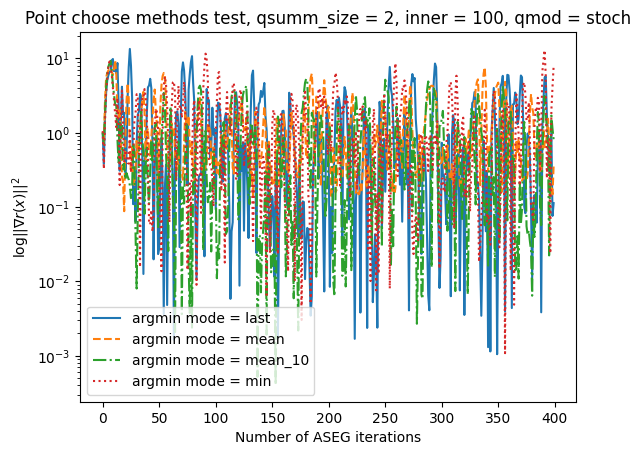

In [62]:
qsumm_test_balanced_step(400,100,q_summ_size = 2, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.617043147939906
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.617043147939906
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.617043147939906
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.617043147939906
task calculated


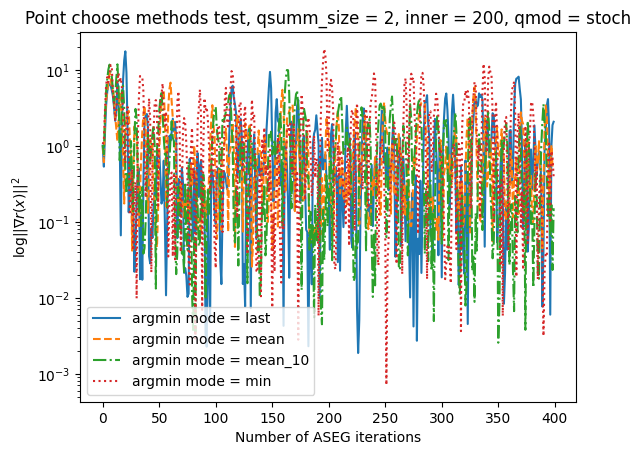

In [63]:
qsumm_test_balanced_step(400,200,q_summ_size = 2, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.411362098626604
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.411362098626604
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.411362098626604
task calculated
number of functions is 20
 convex constants : Lp = 21.994861740790608, Lq = 43.631539419300154
q summ size is 2
stoch mod
subsubsub
coef = {} 0.411362098626604
task calculated


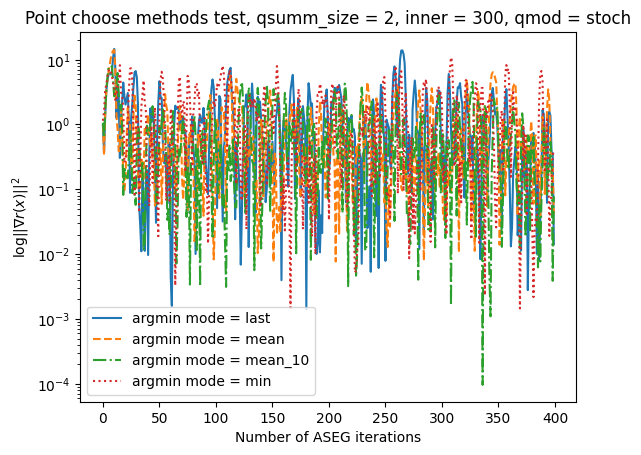

In [64]:
qsumm_test_balanced_step(400,300,q_summ_size = 2, q_mod = "stoch")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2 + f_3

number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 1.8619467005081387
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 1.8619467005081387
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 1.8619467005081387
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 1.8619467005081387
task calculated


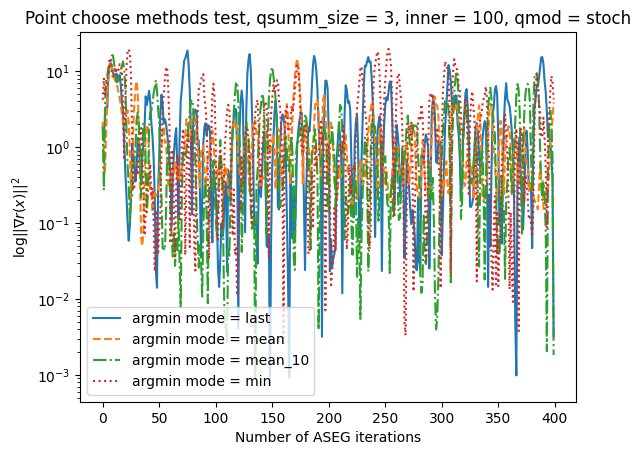

In [65]:
qsumm_test_balanced_step(400,100,q_summ_size = 3, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.9309733502540694
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.9309733502540694
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.9309733502540694
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.9309733502540694
task calculated


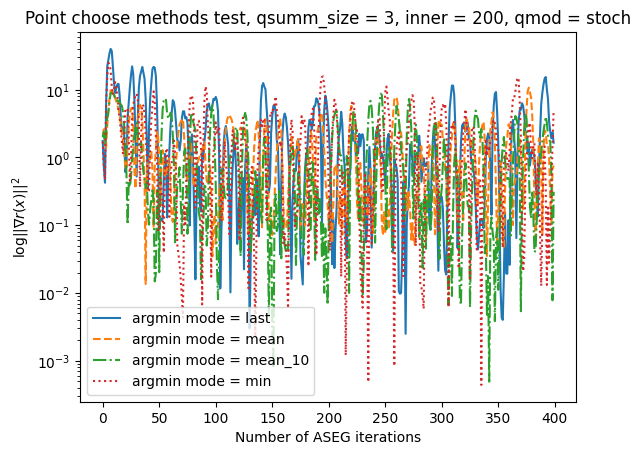

In [66]:
qsumm_test_balanced_step(400,200,q_summ_size = 3, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.6206489001693796
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.6206489001693796
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.6206489001693796
task calculated
number of functions is 20
 convex constants : Lp = 43.68380735637184, Lq = 65.82975690686112
q summ size is 3
stoch mod
subsubsub
coef = {} 0.6206489001693796
task calculated


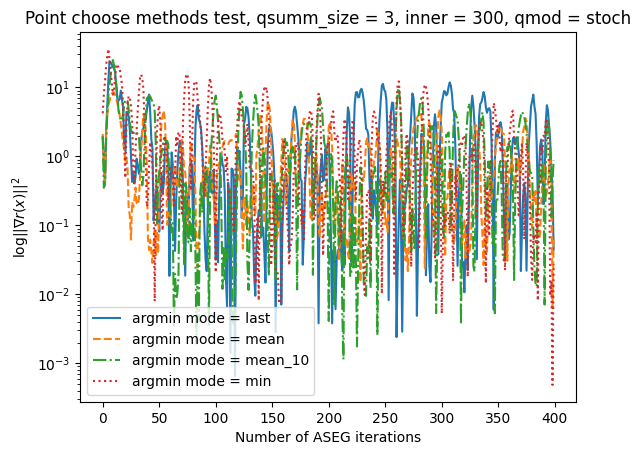

In [67]:
qsumm_test_balanced_step(400,300,q_summ_size = 3, q_mod = "stoch")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, стох сумма на 5 слагаемых

number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 6.171460928059413
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 6.171460928059413
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 6.171460928059413
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 6.171460928059413
task calculated


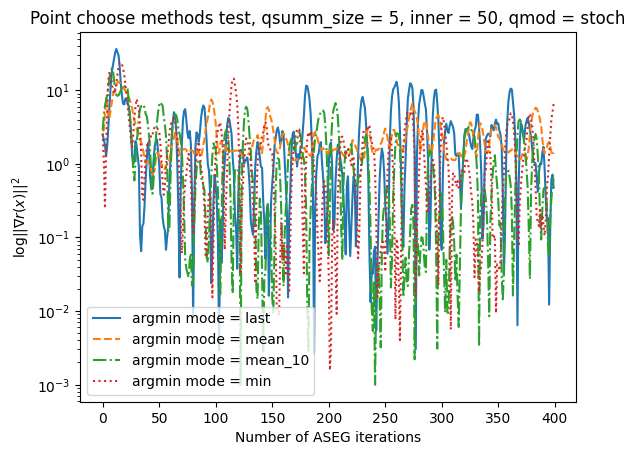

In [68]:
qsumm_test_balanced_step(400,50,q_summ_size = 5, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 3.0857304640297065
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 3.0857304640297065
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 3.0857304640297065
task calculated
number of functions is 20
 convex constants : Lp = 86.21946317336926, Lq = 109.09704680146586
q summ size is 5
stoch mod
subsubsub
coef = {} 3.0857304640297065
task calculated


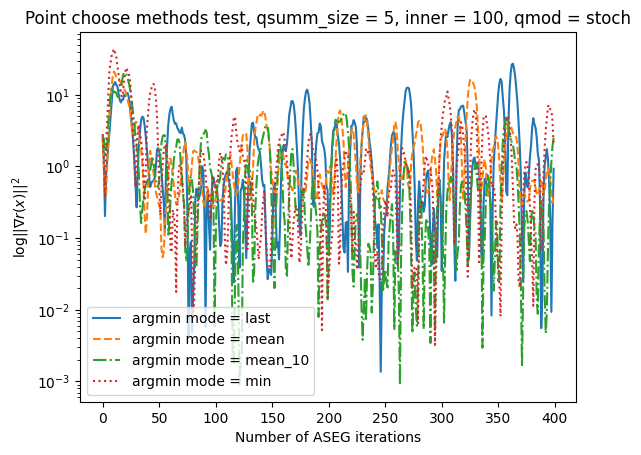

In [69]:
qsumm_test_balanced_step(400,100,q_summ_size = 5, q_mod = "stoch")

##Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, стох сумма на 10 слагаемых

number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 12.368388954944335
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 12.368388954944335
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 12.368388954944335
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 12.368388954944335
task calculated


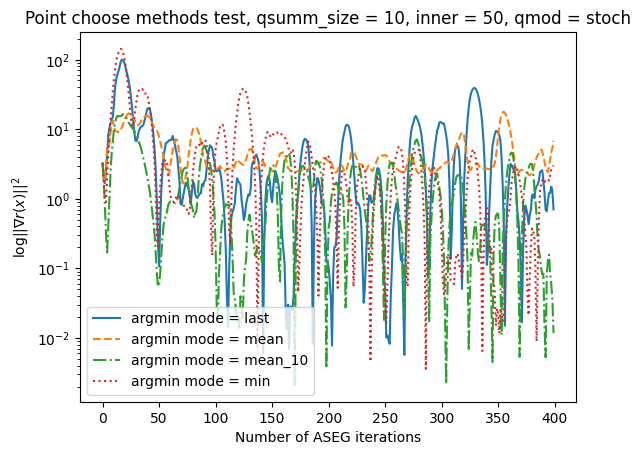

In [70]:
qsumm_test_balanced_step(400,50,q_summ_size = 10, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 6.184194477472167
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 6.184194477472167
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 6.184194477472167
task calculated
number of functions is 20
 convex constants : Lp = 194.05823767574407, Lq = 218.64429255984837
q summ size is 10
stoch mod
subsubsub
coef = {} 6.184194477472167
task calculated


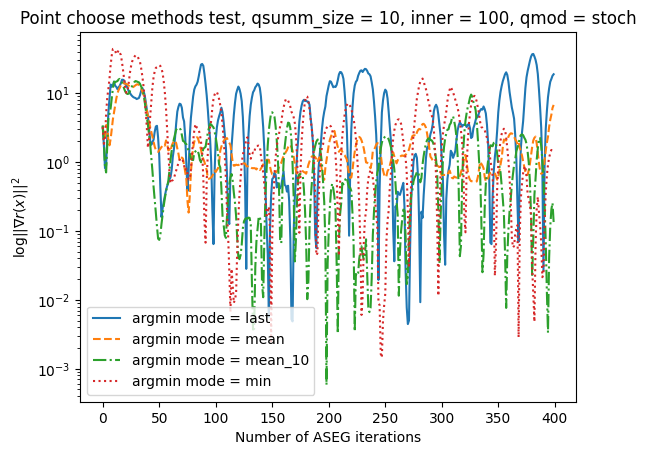

In [71]:
qsumm_test_balanced_step(400,100,q_summ_size = 10, q_mod = "stoch")

##Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, стох сумма на 15 слагаемых

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 9.259501181400111
task calculated


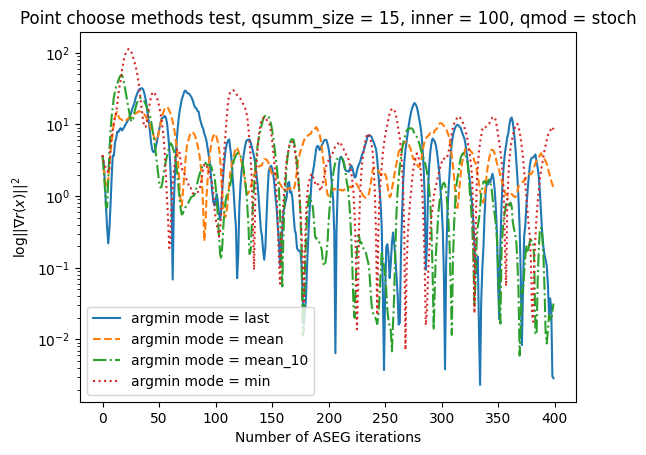

In [72]:
qsumm_test_balanced_step(400,100,q_summ_size = 15, q_mod = "stoch")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
detdetdet
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
detdetdet
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
detdetdet
coef = {} 9.259501181400111
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
detdetdet
coef = {} 9.259501181400111
task calculated


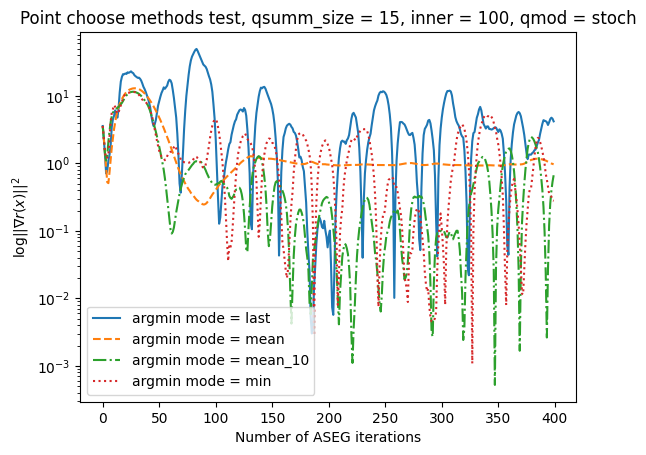

In [146]:
qsumm_test_balanced_step(400,100,q_summ_size = 15, q_mod = "stoch", p_mod="det")

number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 4.629750590700056
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 4.629750590700056
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 4.629750590700056
task calculated
number of functions is 20
 convex constants : Lp = 301.04661370699307, Lq = 327.3728037886433
q summ size is 15
stoch mod
subsubsub
coef = {} 4.629750590700056
task calculated


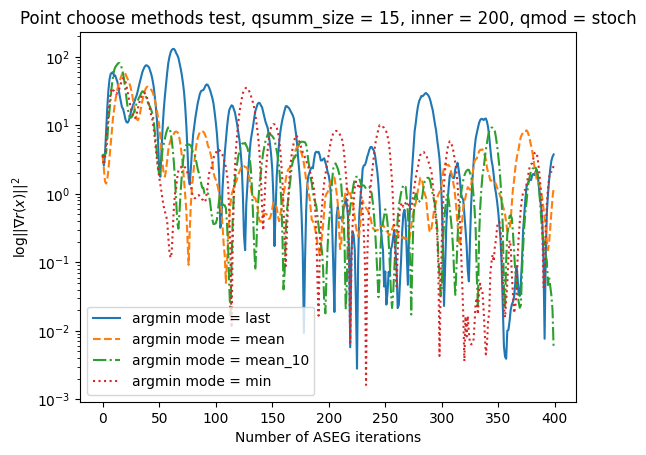

In [73]:
qsumm_test_balanced_step(400,200,q_summ_size = 15, q_mod = "stoch")

## Как работают разные выборы точек на стохастическом процентном случае (1 процента отклонение) при разном количестве внутренних итераций

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.6124416491899874
task calculated


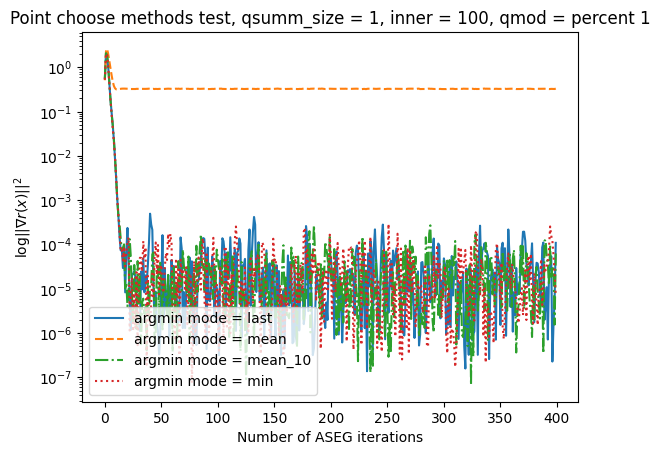

In [74]:
qsumm_test_balanced_step(400,100,1, q_mod = "percent", percent = 1)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.3062208245949937
task calculated


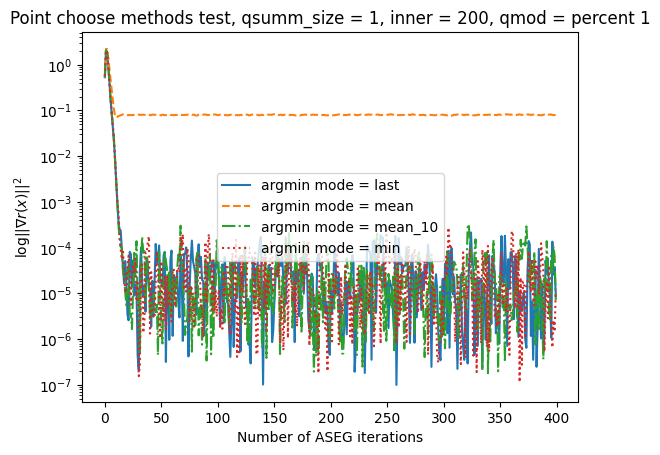

In [75]:
qsumm_test_balanced_step(400,200,1, q_mod = "percent", percent = 1)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 1
subsubsub
coef = {} 0.2041472163966625
task calculated


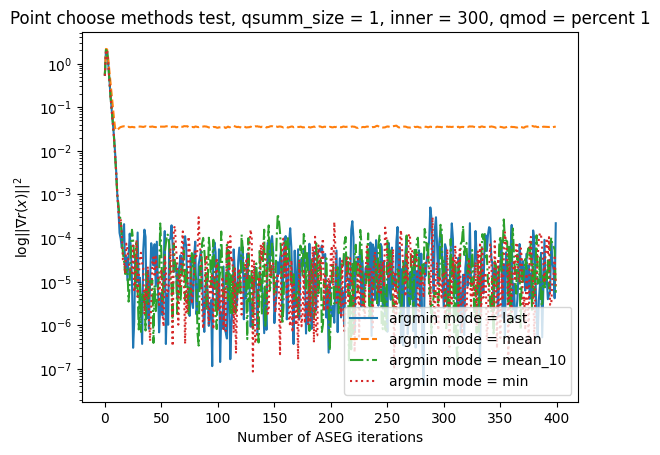

In [76]:
qsumm_test_balanced_step(400,300,1, q_mod = "percent", percent = 1)

## Как работают разные выборы точек на стохастическом процентном случае (8 процента отклонение) при разном количестве внутренних итераций

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.6124416491899874
task calculated


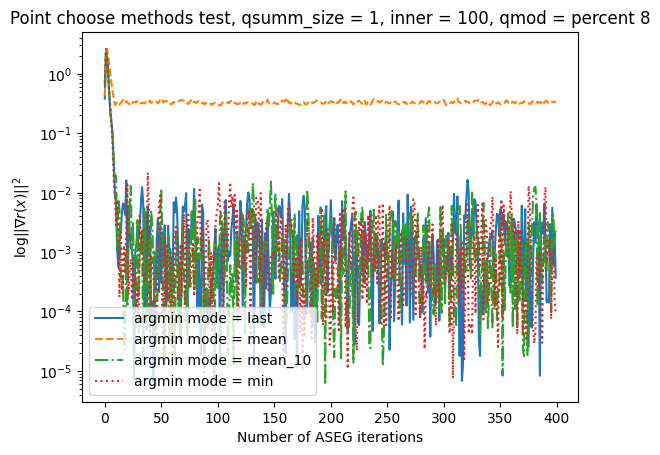

In [77]:
qsumm_test_balanced_step(400,100,1, q_mod = "percent", percent = 8)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.3062208245949937
task calculated


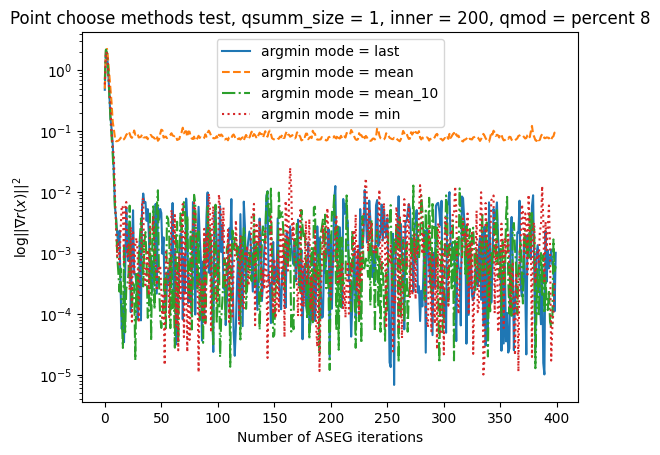

In [78]:
qsumm_test_balanced_step(400,200,1, q_mod = "percent", percent = 8)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 8
subsubsub
coef = {} 0.2041472163966625
task calculated


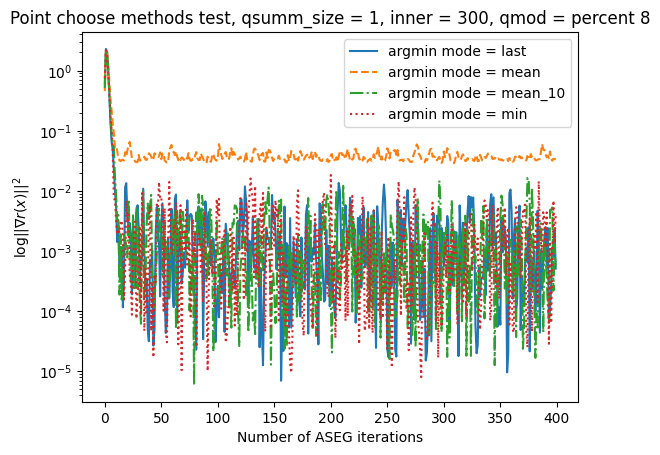

In [79]:
qsumm_test_balanced_step(400,300,1, q_mod = "percent", percent = 8)

## Как работают разные выборы точек на стохастическом процентном случае (20 процента отклонение) при разном количестве внутренних итераций

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.6124416491899874
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.6124416491899874
task calculated


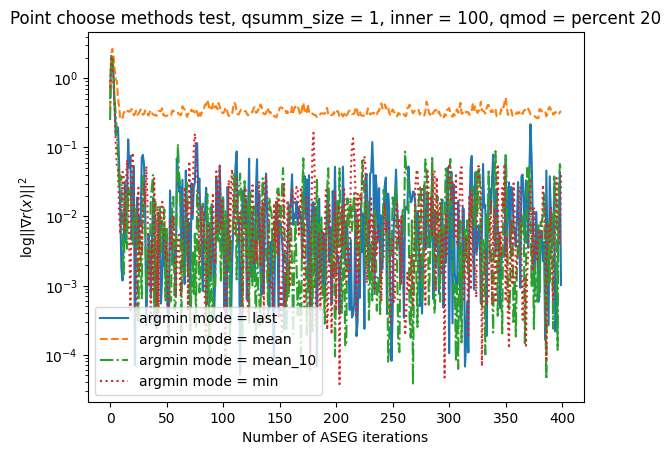

In [80]:
qsumm_test_balanced_step(400,100,1, q_mod = "percent", percent = 20)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.3062208245949937
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.3062208245949937
task calculated


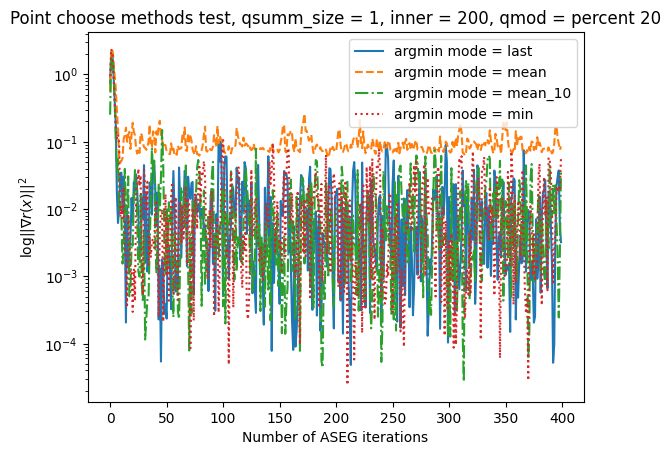

In [81]:
qsumm_test_balanced_step(400,200,1, q_mod = "percent", percent = 20)

number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.2041472163966625
task calculated
number of functions is 20
 convex constants : Lp = 3.3545924725534184, Lq = 21.65308216116564
q summ size is 1
percent mod 20
subsubsub
coef = {} 0.2041472163966625
task calculated


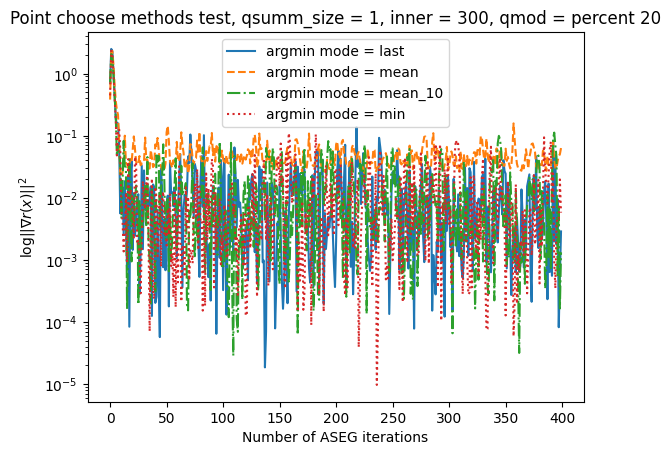

In [82]:
qsumm_test_balanced_step(400,300,1, q_mod = "percent", percent = 20)

# Тест : сравнение способов выбора итоговой точки в подзадаче, шаг $\gamma_m = \frac{2}{L \sqrt m}$

In [ ]:
def qsumm_test_smart_step(outer,inner, q_summ_size = 1, q_mod = "det", N_size = 50, reg_coef = 1/100, percent = 3):
  point_choose_mods = ["last","mean","mean_10","min"]
  styles = ["-","--","-.",":"]
#  point_choose_mods = point_choose_mods[1:2]

  logs = []
  for i in range(len(point_choose_mods)):
    task = get_default_task(q_summ_size, q_mod, N_size, reg_coef, percent)
    logs.append(task.calculate(outer_iterations = outer, inner_iterations = inner, argmin_mod = point_choose_mods[i], step = smart_variable_step )[1])
    print("task calculated")
    plt.plot(range(len(logs[i])),logs[i], label = "argmin mode = " + point_choose_mods[i], linestyle = styles[i])
  if(q_mod == "percent"):
    plt.title("Point choose methods test smart step, qsumm_size = {}, inner = {}, qmod = {} {}".format(q_summ_size,inner, q_mod, percent))
  else:
    plt.title("Point choose methods test smart step, qsumm_size = {}, inner = {}, qmod = {}".format(q_summ_size,inner, q_mod))
  plt.legend()
  plt.xlabel("Number of ASEG iterations")
  plt.yscale("log")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2

number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated


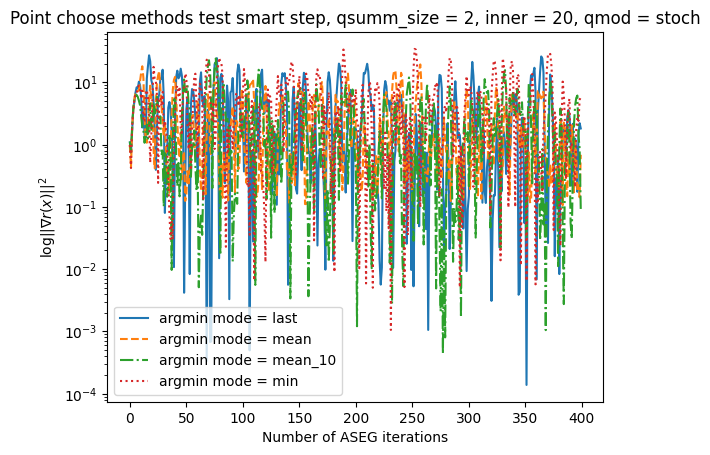

In [ ]:
qsumm_test_smart_step(400,20,q_summ_size = 2, q_mod = "stoch")

number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated


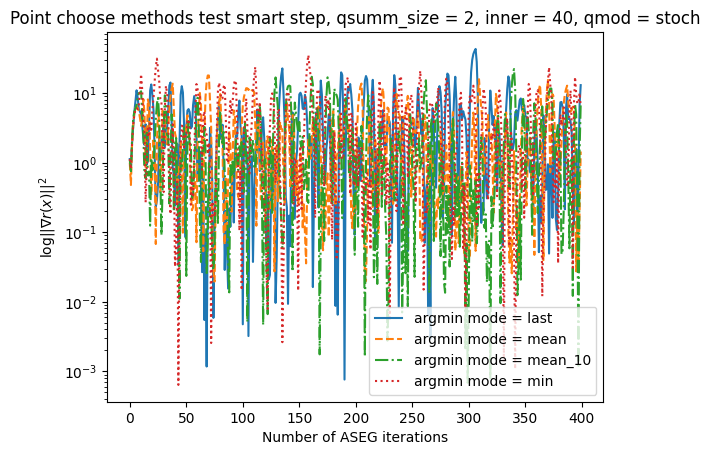

In [ ]:
qsumm_test_smart_step(400,40,q_summ_size = 2, q_mod = "stoch")

number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 22.040226150155544, Lq = 43.63159119222286
q summ size is 2
stoch mod
task calculated


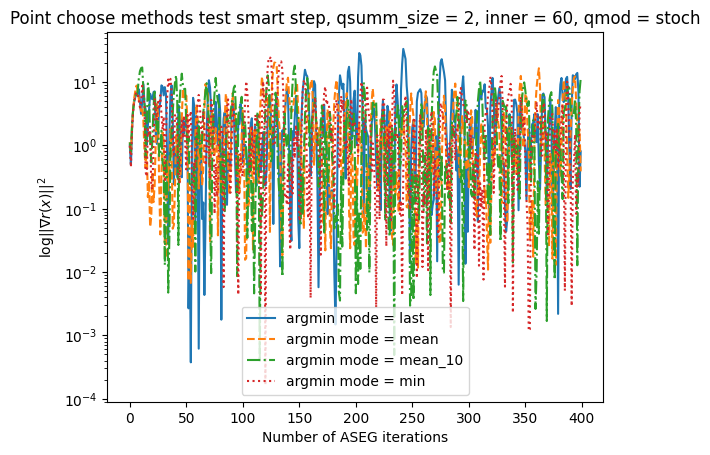

In [ ]:
qsumm_test_smart_step(400,60,q_summ_size = 2, q_mod = "stoch")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2 + f_3

number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated


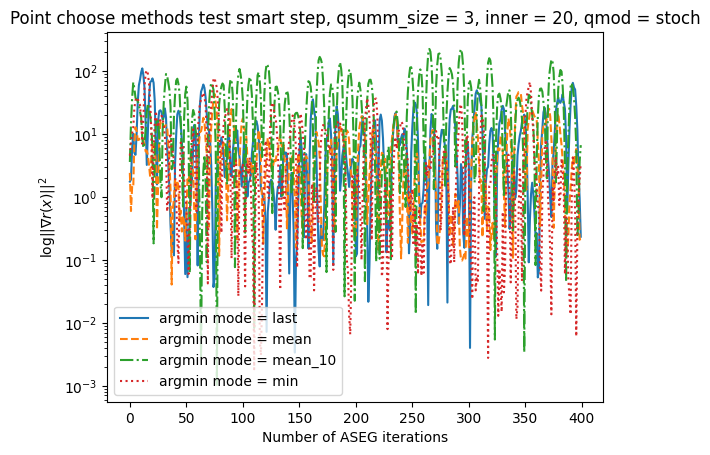

In [ ]:
qsumm_test_smart_step(400,20,q_summ_size = 3, q_mod = "stoch")

number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated


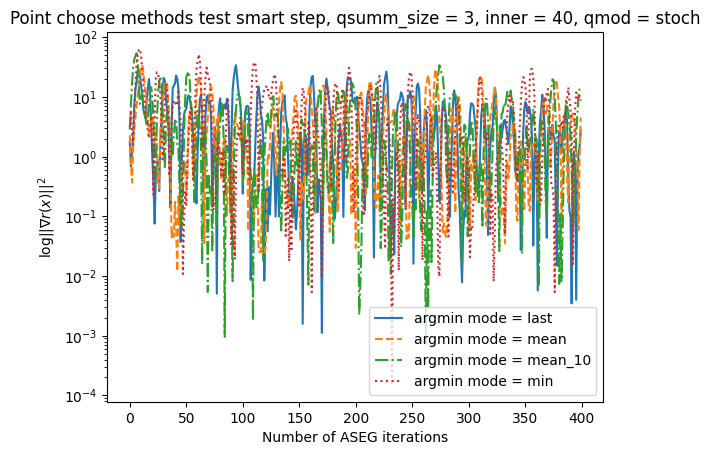

In [ ]:
qsumm_test_smart_step(400,40,q_summ_size = 3, q_mod = "stoch")

number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated
number of functions is 50
 convex constants : Lp = 43.556262178933586, Lq = 66.22393641134519
q summ size is 3
stoch mod
task calculated


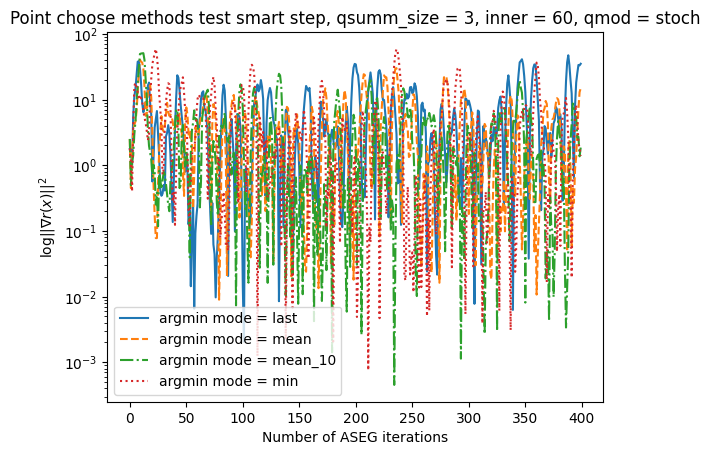

In [ ]:
qsumm_test_smart_step(400,60,q_summ_size = 3, q_mod = "stoch")

## Как работают разные выборы точек на стохастическом процентном случае (3 процента отклонение) при разном количестве внутренних итераций

number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated


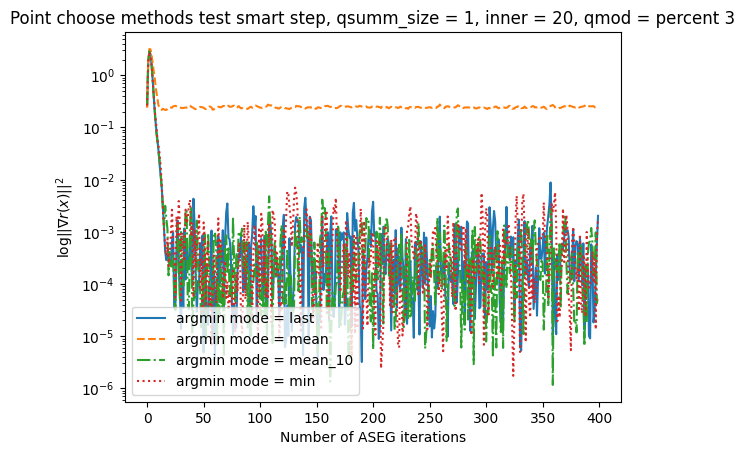

In [ ]:
qsumm_test_smart_step(400,20,1, q_mod = "percent", percent = 3)

number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated


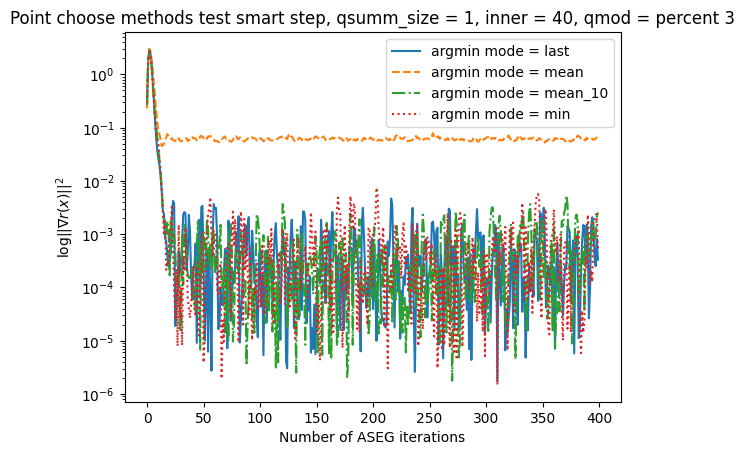

In [ ]:
qsumm_test_smart_step(400,40,1, q_mod = "percent", percent = 3)

number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 3
task calculated


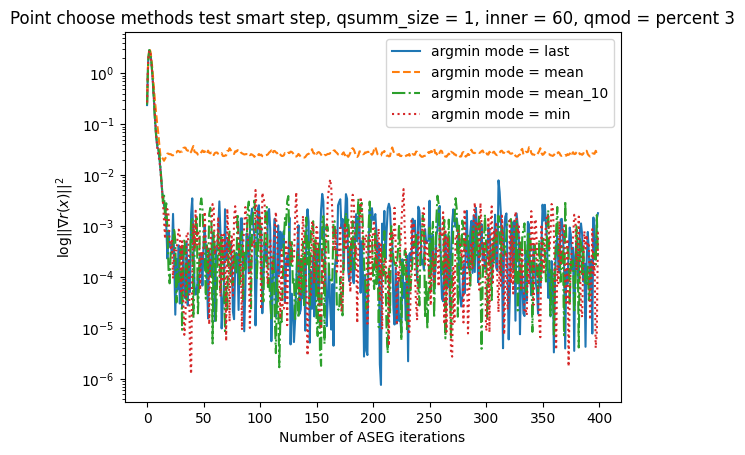

In [ ]:
qsumm_test_smart_step(400,60,1, q_mod = "percent", percent = 3)

## Как работают разные выборы точек на стохастическом процентном случае (8 процента отклонение) при разном количестве внутренних итераций

number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated


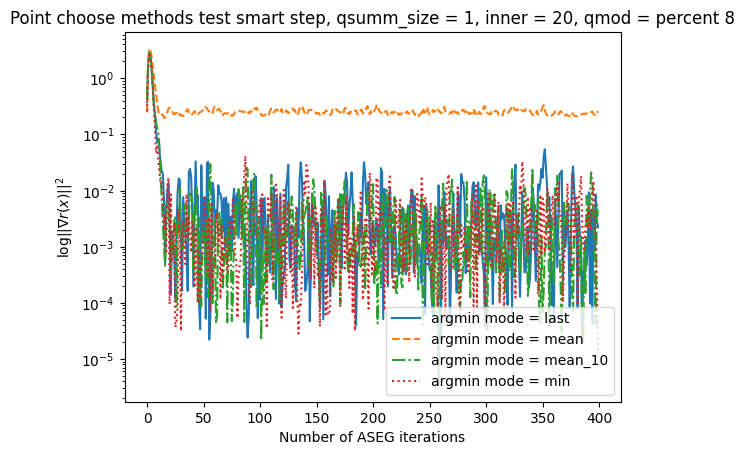

In [ ]:
qsumm_test_smart_step(400,20,1, q_mod = "percent", percent = 8)

In [ ]:
qsumm_test_smart_step(400,40,1, q_mod = "percent", percent = 8)

number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8
task calculated
number of functions is 50
 convex constants : Lp = 5.521648304627886, Lq = 21.572189851751258
q summ size is 1
percent mod 8


In [ ]:
qsumm_test_smart_step(400,60,1, q_mod = "percent", percent = 8)

## Как работают разные выборы точек на стохастическом процентном случае (20 процента отклонение) при разном количестве внутренних итераций

In [ ]:
qsumm_test_smart_step(400,20,1, q_mod = "percent", percent = 20)

In [ ]:
qsumm_test_smart_step(400,40,1, q_mod = "percent", percent = 20)

In [ ]:
qsumm_test_smart_step(400,60,1, q_mod = "percent", percent = 20)

# Тест : cравнение способов выбора итоговой точки в подзадаче, шаг $\gamma = \frac{1}{2L}$

In [ ]:
def qsumm_test(outer,inner, q_summ_size = 1, q_mod = "det", N_size = 50, reg_coef = 1/100, percent = 3):
  point_choose_mods = ["last","mean","mean_10","min"]
  styles = ["-","--","-.",":"]
#  point_choose_mods = point_choose_mods[1:2]

  logs = []
  for i in range(len(point_choose_mods)):
    task = get_default_task(q_summ_size, q_mod, N_size, reg_coef, percent)
    logs.append(task.calculate(outer_iterations = outer, inner_iterations = inner, argmin_mod = point_choose_mods[i])[1])
    print("task calculated")
    plt.plot(range(len(logs[i])),logs[i], label = "argmin mode = " + point_choose_mods[i], linestyle = styles[i])
  if(q_mod == "percent"):
    plt.title("Point choose methods test, qsumm_size = {}, inner = {}, qmod = {} {}".format(q_summ_size,inner, q_mod, percent))
  else:
    plt.title("Point choose methods test, qsumm_size = {}, inner = {}, qmod = {}".format(q_summ_size,inner, q_mod))
  plt.legend()
  plt.xlabel("Number of ASEG iterations")
  plt.yscale("log")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

## Как работают разные выборы точек на детерменированном случае при разном количестве внутренних шагов

In [ ]:
qsumm_test(100,12,q_summ_size = 1, q_mod = "det")

In [ ]:
qsumm_test(100,20,q_summ_size = 1, q_mod = "det")

In [ ]:
qsumm_test(100,30,q_summ_size = 1, q_mod = "det")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2

In [ ]:
qsumm_test(100,12,q_summ_size = 2, q_mod = "stoch")

In [ ]:
qsumm_test(100,20,q_summ_size = 2, q_mod = "stoch")

In [ ]:
qsumm_test(100,30,q_summ_size = 2, q_mod = "stoch")

## Как работают разные выборы точек на стох случае при разном количестве внутренних шагов, q = f_1 + f_2 + f_3

In [ ]:
qsumm_test(400,20,q_summ_size = 3, q_mod = "stoch")

In [ ]:
qsumm_test(400,40,q_summ_size = 3, q_mod = "stoch")

In [ ]:
qsumm_test(400,60,q_summ_size = 3, q_mod = "stoch")

## Как работают разные выборы точек на стохастическом процентном случае (3 процента отклонение) при разном количестве внутренних итераций

In [ ]:
qsumm_test(400,20,1, q_mod = "percent", percent = 3)

In [ ]:
qsumm_test(400,40,1, q_mod = "percent", percent = 3)

In [ ]:
qsumm_test(400,60,1, q_mod = "percent", percent = 3)

## Как работают разные выборы точек на стохастическом процентном случае (8 процента отклонение) при разном количестве внутренних итераций

In [ ]:
qsumm_test(400,20,1, q_mod = "percent", percent = 8)

In [ ]:
qsumm_test(400,40,1, q_mod = "percent", percent = 8)

In [ ]:
qsumm_test(400,60,1, q_mod = "percent", percent = 8)

## Как работают разные выборы точек на стохастическом процентном случае (20 процента отклонение) при разном количестве внутренних итераций

In [ ]:
qsumm_test(400,20,1, q_mod = "percent", percent = 20)

In [ ]:
qsumm_test(400,40,1, q_mod = "percent", percent = 20)

In [ ]:
qsumm_test(400,60,1, q_mod = "percent", percent = 20)

# Тест кусуммы c константным шагом с последней возвращаемой точкой

## Тест детерменированной суммы

In [ ]:
def qsumm_test(outer,inner,q_summ_size=[1,3,5], N_size = 200, reg_coef = 1/100):
  logs=[]
  for i in range(len(q_summ_size)):
    task = get_default_task(q_summ_size = q_summ_size[i], q_mod = "det", N_size = N_size, reg_coef = reg_coef)
    logs.append(task.calculate(outer,inner, argmin_mod = "last")[1])оеаенсчапебнгадшюна
    plt.plot(range(len(logs[i])),logs[i],label='qsumm_size = {}'.format(q_summ_size[i]))
  plt.legend()
  plt.title("mushrooms det qsumm_test, inner = {}".format(inner))
  plt.yscale("log")
  plt.xlabel("Number of ASEG iteration")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

In [ ]:
qsumm_test(500,10,[1,2,3,4], N_size=200, reg_coef = 1/100)

In [ ]:
qsumm_test(500, 20,[1,2,3,4], N_size=200, reg_coef = 1/100)

In [ ]:
qsumm_test(500, 30,[1,2,3,4], N_size=200, reg_coef = 1/100)

## Тест стохастической суммы

In [ ]:
def qsumm_stoch_test(outer,inner,q_summ_size=[1,2], N_size = 200, reg_coef = 1/100):
  logs=[]
  for i in range(len(q_summ_size)):
    task = get_default_task(q_summ_size[i],q_mod = "stoch", N_size = N_size, reg_coef = reg_coef)
    logs.append(task.calculate(outer,inner,theta_coef=1)[1])
    plt.plot(range(len(logs[i])),logs[i],label='qsumm_size = {}'.format(q_summ_size[i]))
  plt.legend()
  plt.title("mushrooms random qsumm_test, inner = {}".format(inner))
  plt.yscale("log")
  plt.xlabel("Number of ASEG iteration")
  plt.ylabel(r"$\log||\nabla r(x)||^2$")

In [ ]:
qsumm_stoch_test(500,10,[1,2,3,4], N_size = 200)

In [ ]:
qsumm_stoch_test(500,20,[1,2,3,4], N_size = 200)

In [ ]:
qsumm_stoch_test(500,30,[1,2,3,4], N_size = 200)

In [ ]:
qsumm_stoch_test(500,100,[1,2,3,4], N_size = 200)

# Тест работы алгоритма grad q шевелится на проценты НАХОДИТСЯ В РЕМОНТЕ

In [ ]:
def algo_test_percents(outer_iterations, inner_iterations, percents=[1,2,3], N_size = 200, reg_coef = 1/100):
  logs=[]
  for i in range(len(percents)):
    task=get_default_task(q_summ_size = 1, q_mod = "percent", N_size = N_size, reg_coef = reg_coef, par = percents[i])
    logs.append(task.calculate(outer_iterations = outer_iterations, inner_iterations = inner_iterations)[1])
    plt.plot(range(len(logs[i])),logs[i],label = "%err = {}".format(percents[i]))
  plt.yscale('log')
  plt.ylabel(r"$\log||\nabla r(x)||^2$")
  plt.xlabel("number of iteration")
  plt.title("Mushrooms percents test : outer = {}, inner = {}".format(outer_iterations, inner_iterations))
  plt.legend()

In [ ]:
algo_test_percents(outer_iterations = 500, inner_iterations = 50, percents=[1,3,5,10],N_size = 200)

In [ ]:
algo_test_percents(outer_iterations = 500, inner_iterations = 100, percents=[1,3,5,10],N_size = 200)

In [ ]:
algo_test_percents(outer_iterations = 500, inner_iterations = 200, percents=[1,3,5,10],N_size = 200)

# Тест функции минимизации подзадачи НАХОДИТСЯ В РЕМОНТЕ

In [ ]:
step = lambda i : classic_step(i, Lq)

In [ ]:
percents = [1,3,5,10,20]
labels = ["1","3","5","10","20"]

In [ ]:
grads=[]
for i in range(len(percents)):
  grads.append(get_stoch_uni_q(functions,percents[i]))

In [ ]:
logs=[]
for i in range(len(grads)):
  logs.append(argmin_A(s_k = grad_p(x_start), theta = 1/3/Lp, x_kg = x_start, grad_q = grads[i], step = step, iterations=50)[1])

In [ ]:
for i in range(len(grads)):
  plt.plot(range(len(logs[i])),logs[i],label = "%err = {}".format(percents[i]))
plt.yscale('log')
plt.ylabel(r"$\log||\nabla A(x)||^2$")
plt.xlabel("number of iteration")
plt.legend()
plt.title("Inner problem percent test on mushrooms")